In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import joblib

In [2]:
DATA_PATH = './MPox-Vision'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

## data augmentation & loading

In [5]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("\nLoading validation data...")
validation_generator = val_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("\nClasses:", class_names)
print("Mapping Label:", train_generator.class_indices)

Loading training data...
Found 640 images belonging to 4 classes.

Loading validation data...
Found 160 images belonging to 4 classes.

Classes: ['Acne', 'Chickenpox', 'Measles', 'Monkeypox']
Mapping Label: {'Acne': 0, 'Chickenpox': 1, 'Measles': 2, 'Monkeypox': 3}


## modeling

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 93s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24,113,284
Trainable params: 525,572
Non-t

## training

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'monkeypox_best_model.keras',
        monitor='val_accuracy',
        save_best_only=True, 
        mode='max',
        verbose=1
    )
]

In [8]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 1.8811 - accuracy: 0.2812
Epoch 1: val_accuracy improved from -inf to 0.55625, saving model to monkeypox_best_model.keras
20/20 [==============================] - 109s 5s/step - loss: 1.8811 - accuracy: 0.2812 - val_loss: 1.0400 - val_accuracy: 0.5562
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 1.1416 - accuracy: 0.5359
Epoch 2: val_accuracy improved from 0.55625 to 0.73125, saving model to monkeypox_best_model.keras
20/20 [==============================] - 90s 5s/step - loss: 1.1416 - accuracy: 0.5359 - val_loss: 0.7266 - val_accuracy: 0.7312
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 0.9484 - accuracy: 0.6125
Epoch 3: val_accuracy improved from 0.73125 to 0.77500, saving model to monkeypox_best_model.keras
20/20 [==============================] - 94s 5s/step - loss: 0.9484 - accuracy: 0.6125 - val_loss: 0.6122 - val_accuracy: 0.7750
Epoch 4/25
20/20 [==================

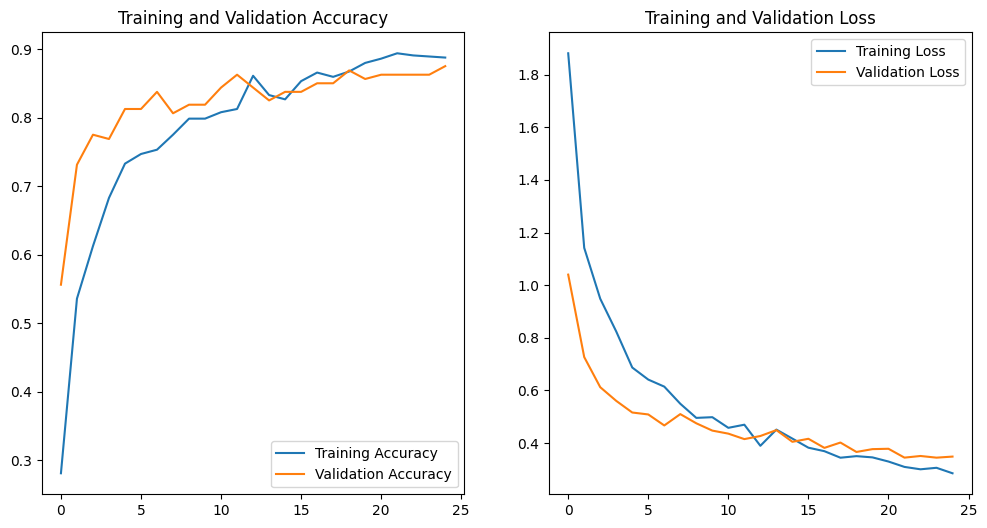

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicting validation set...

5/5 [==============================] - 21s 4s/step
CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Acne       0.77      1.00      0.87        40
  Chickenpox       0.91      0.72      0.81        40
     Measles       0.97      0.88      0.92        40
   Monkeypox       0.90      0.90      0.90        40

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.87       160
weighted avg       0.89      0.88      0.87       160


CONFUSION MATRIX


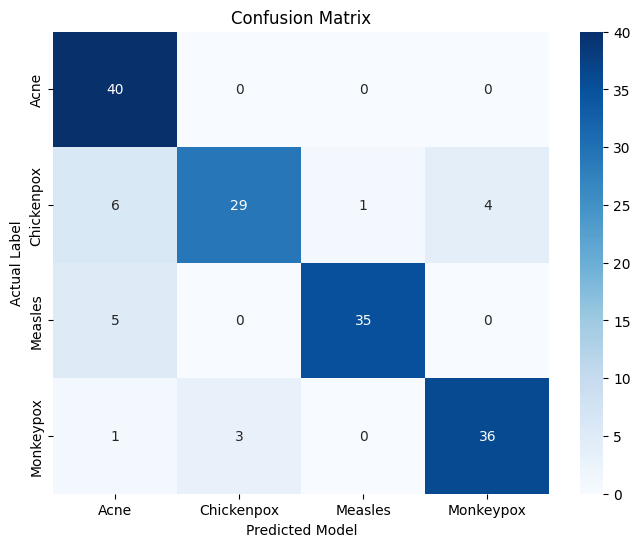

In [10]:
print("Predicting validation set...\n")

validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

y_true = validation_generator.classes

class_names = list(validation_generator.class_indices.keys())

print("CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nCONFUSION MATRIX")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Model')
plt.title('Confusion Matrix')
plt.show()

In [11]:
path_gambar = './MPox-Vision/Acne/AN_1.png'

img = image.load_img(path_gambar, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

images = np.vstack([x])
probs = model.predict(images)[0]
class_idx = np.argmax(probs)

print(f"\nPredicted Model: {class_names[class_idx]}")
print(f"Confidence: {probs[class_idx]*100:.2f}%")

print("\nProbability Details:")
for i, name in enumerate(class_names):
    print(f"- {name}: {probs[i]*100:.2f}%")

1/1 [==============================] - 2s 2s/step

Predicted Model: Acne
Confidence: 96.08%

Probability Details:
- Acne: 96.08%
- Chickenpox: 3.78%
- Measles: 0.04%
- Monkeypox: 0.10%


In [13]:
from sklearn.utils import metadata_routing
print("Saving model...\n")

model_path = './monkeypox_model_final.keras'
model.save(model_path)
print(f'Model saved successfully')

model_metadata = {
    'class_names': class_names,
    'class_indices': train_generator.class_indices,
    'img_size': IMG_SIZE,
    'input_shape': (224, 224, 3),
    'num_classes': len(class_names),
    'preprocessing': 'resnet50_preprocess_input'
}

metadata_path = './model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print('Model saved successfully')

Saving model...

Model saved successfully
Model saved successfully
